In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers.core import Dense
from keras.optimizers import RMSprop
from keras.layers import LSTM, Dropout
from rbf_layer import RBFLayer, InitCentersRandom
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.linear_model import LinearRegression

In [2]:
COMPANY = 'opl'

In [3]:
def roll_beta(window_size, stock, market):
    data = {'X': market, 'Y': stock}
    df = pd.DataFrame(data)
    cov = df.X.rolling(window=window_size).cov(df.Y)
    var = df.X.rolling(window=window_size).var()
    roling_beta = cov/var
    return np.array(roling_beta[window_size - 1:])

In [4]:
def return_from_stock(stock_data):
    stock = pd.read_csv(f"{stock_data}")
    #creating new column 'return' it is percentage change between current and last month close price
    stock['return'] = stock.Zamkniecie.pct_change()
    return np.array(stock['return'][1:]) # first value is NaN so [1:]

In [5]:
wig_20_return = return_from_stock('wig20_m.csv')
peo_return = return_from_stock('opl_m.csv')

In [6]:
peo_roll_beta = roll_beta(36, peo_return, wig_20_return)

In [7]:
peo_roll_beta

array([0.94037476, 0.94354325, 0.93509167, 0.95579888, 0.88216939,
       0.91755991, 0.983653  , 0.98071446, 0.97308049, 1.01192984,
       1.0005119 , 1.01193674, 0.98591432, 0.99433807, 1.00992793,
       0.99895448, 1.00095201, 1.03578783, 1.00961806, 0.96027802,
       0.79957442, 0.74984196, 0.73875278, 0.67754607, 0.6780309 ,
       0.59496599, 0.59514895, 0.59070436, 0.52190391, 0.47681262,
       0.50185068, 0.51304411, 0.49086036, 0.52406865, 0.52582584,
       0.41352692, 0.38167023, 0.37596981, 0.31092136, 0.31515194,
       0.31497266, 0.29887769, 0.2888617 , 0.27722638, 0.27075128,
       0.25076025, 0.24545359, 0.25104226, 0.25480261, 0.22018932,
       0.25835266, 0.2540453 , 0.26454544, 0.23385928, 0.22412783,
       0.22553469, 0.25583074, 0.25440514, 0.25487536, 0.25433218,
       0.25286164, 0.2677704 , 0.23401524, 0.22908078, 0.2210684 ,
       0.14687314, 0.10275169, 0.13262128, 0.15456222, 0.0666996 ,
       0.03584655, 0.16656116, 0.17860469, 0.2069995 , 0.30277

In [8]:
# creating training dataset
df_data = pd.DataFrame({
    'target': peo_roll_beta,
    't-1': np.roll(peo_roll_beta, 1),
    't-2': np.roll(peo_roll_beta, 2),
    't-3': np.roll(peo_roll_beta, 3),
    't-4': np.roll(peo_roll_beta, 4),
    't-5': np.roll(peo_roll_beta, 5)
})


In [9]:
df_data = df_data.iloc[5:]
df_data

,target,t-1,t-2,t-3,t-4,t-5
5,0.917560,0.882169,0.955799,0.935092,0.943543,0.940375
6,0.983653,0.917560,0.882169,0.955799,0.935092,0.943543
7,0.980714,0.983653,0.917560,0.882169,0.955799,0.935092
8,0.973080,0.980714,0.983653,0.917560,0.882169,0.955799
9,1.011930,0.973080,0.980714,0.983653,0.917560,0.882169
...,...,...,...,...,...,...
200,0.515959,0.511043,0.506119,0.519858,0.471351,0.407687
201,0.486928,0.515959,0.511043,0.506119,0.519858,0.471351
202,0.498758,0.486928,0.515959,0.511043,0.506119,0.519858
203,0.451214,0.498758,0.486928,0.515959,0.511043,0.506119


In [10]:
X = df_data.iloc[:, -5:]
X

,t-1,t-2,t-3,t-4,t-5
5,0.882169,0.955799,0.935092,0.943543,0.940375
6,0.917560,0.882169,0.955799,0.935092,0.943543
7,0.983653,0.917560,0.882169,0.955799,0.935092
8,0.980714,0.983653,0.917560,0.882169,0.955799
9,0.973080,0.980714,0.983653,0.917560,0.882169
...,...,...,...,...,...
200,0.511043,0.506119,0.519858,0.471351,0.407687
201,0.515959,0.511043,0.506119,0.519858,0.471351
202,0.486928,0.515959,0.511043,0.506119,0.519858
203,0.498758,0.486928,0.515959,0.511043,0.506119


In [11]:
X = X[X.columns[::-1]]
X

,t-5,t-4,t-3,t-2,t-1
5,0.940375,0.943543,0.935092,0.955799,0.882169
6,0.943543,0.935092,0.955799,0.882169,0.917560
7,0.935092,0.955799,0.882169,0.917560,0.983653
8,0.955799,0.882169,0.917560,0.983653,0.980714
9,0.882169,0.917560,0.983653,0.980714,0.973080
...,...,...,...,...,...
200,0.407687,0.471351,0.519858,0.506119,0.511043
201,0.471351,0.519858,0.506119,0.511043,0.515959
202,0.519858,0.506119,0.511043,0.515959,0.486928
203,0.506119,0.511043,0.515959,0.486928,0.498758


In [12]:
y = df_data.target
y

5      0.917560
6      0.983653
7      0.980714
8      0.973080
9      1.011930
         ...   
200    0.515959
201    0.486928
202    0.498758
203    0.451214
204    0.467882
Name: target, Length: 200, dtype: float64

In [13]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=0, shuffle=False)

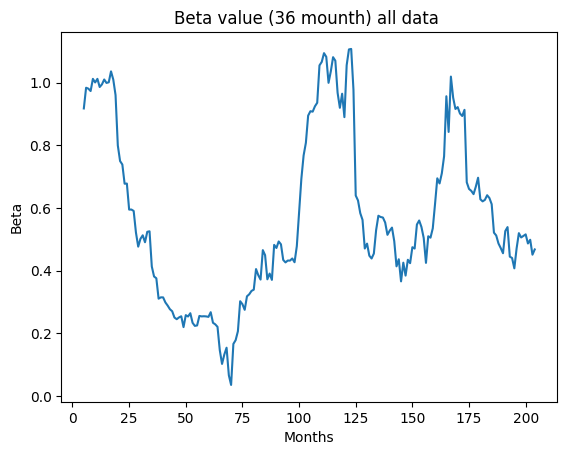

In [14]:
plt.plot(y)
plt.xlabel('Months')
plt.ylabel('Beta')
plt.title('Beta value (36 mounth) all data ')
plt.savefig(f'all_data{COMPANY}.png')

In [15]:
y_test

165    0.956443
166    0.842687
167    1.019182
168    0.951748
169    0.915941
170    0.921819
171    0.901423
172    0.893487
173    0.913197
174    0.682067
175    0.660911
176    0.654677
177    0.644287
178    0.668167
179    0.696685
180    0.627966
181    0.621194
182    0.625962
183    0.640806
184    0.631859
185    0.612164
186    0.521441
187    0.512413
188    0.486935
189    0.472199
190    0.455777
191    0.526438
192    0.539188
193    0.444975
194    0.440717
195    0.407687
196    0.471351
197    0.519858
198    0.506119
199    0.511043
200    0.515959
201    0.486928
202    0.498758
203    0.451214
204    0.467882
Name: target, dtype: float64

In [16]:
def single_plot(y_pred, y_real, title):
    x = np.arange(1, len(y_pred) + 1)
    plt.plot(x,y_real, label='real')
    plt.plot(x,y_pred, label='predicted')
    plt.xlabel('day')
    plt.ylabel('month')
    plt.legend()
    plt.title(title)
    return plt.plot()

In [17]:
def generate_plots(y_pred_train, y_pred_test, y_train, y_test, title_1, title_2, to_png, png_name):
    fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(8, 6))

    ax = axes[0]  # Wybór odpowiedniej osi
    plt.sca(ax)  # Ustawienie bieżącej osi
    single_plot(y_pred_train, y_train, title_1)

    ax = axes[1]  # Wybór odpowiedniej osi
    plt.sca(ax)  # Ustawienie bieżącej osi
    single_plot(y_pred_test, y_test, title_2)

    plt.tight_layout()
    if to_png:
        plt.savefig(f'{png_name}.png')
    plt.show()

## Bulding RBF network model

In [18]:
model = Sequential()
rbflayer = RBFLayer(10,
                    initializer=InitCentersRandom(X_train),
                    betas=2.0,
                    input_shape=(5,))
model.add(rbflayer)
model.add(Dense(1))

model.compile(loss='mean_squared_error',
              optimizer=RMSprop())


model.fit(X_train, y_train,
          batch_size=10,
          epochs=200,
          verbose=1)

Epoch 1/200
16/16 [==============================] - 1s 2ms/step - loss: 0.4595
Epoch 2/200
16/16 [==============================] - 0s 2ms/step - loss: 0.3364
Epoch 3/200
16/16 [==============================] - 0s 1ms/step - loss: 0.2627
Epoch 4/200
16/16 [==============================] - 0s 1ms/step - loss: 0.2054
Epoch 5/200
16/16 [==============================] - 0s 2ms/step - loss: 0.1614
Epoch 6/200
16/16 [==============================] - 0s 2ms/step - loss: 0.1305
Epoch 7/200
16/16 [==============================] - 0s 1ms/step - loss: 0.1087
Epoch 8/200
16/16 [==============================] - 0s 2ms/step - loss: 0.0923
Epoch 9/200
16/16 [==============================] - 0s 2ms/step - loss: 0.0790
Epoch 10/200
16/16 [==============================] - 0s 2ms/step - loss: 0.0680
Epoch 11/200
16/16 [==============================] - 0s 2ms/step - loss: 0.0584
Epoch 12/200
16/16 [==============================] - 0s 2ms/step - loss: 0.0506
Epoch 13/200
16/16 [=================

2/2 [==============================] - 0s 2ms/step


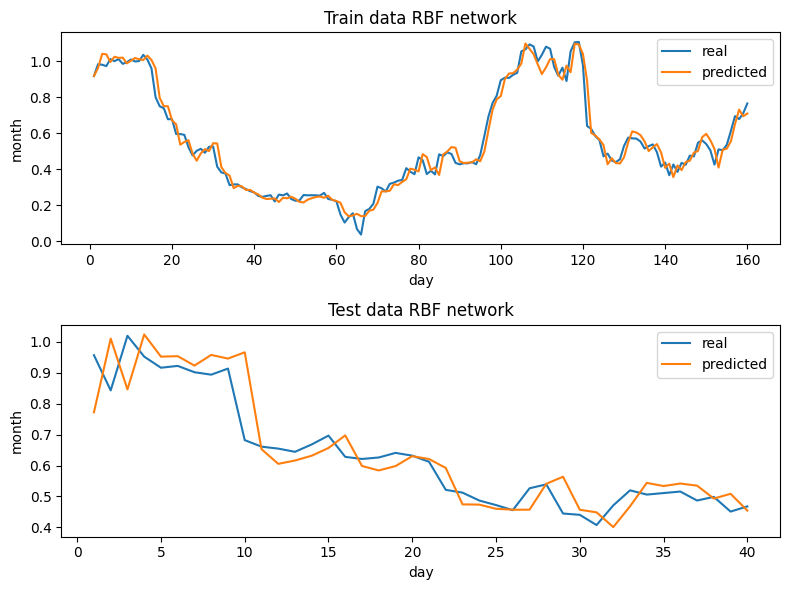

In [19]:
y_pred_train = model.predict(X_train)
y_pred_test = model.predict(X_test)
generate_plots(y_pred_train, y_pred_test, y_train, y_test, 'Train data RBF network', 'Test data RBF network', True, f'RBF_{COMPANY}')

In [20]:
import matplotlib.pyplot as plt

def score_table(y_train, y_pred_train, y_test, y_pred_test, title):
    mse_train = mean_squared_error(y_train, y_pred_train)
    mae_train = mean_absolute_error(y_train, y_pred_train)
    r2_train = r2_score(y_train, y_pred_train)

    mse_test = mean_squared_error(y_test, y_pred_test)
    mae_test = mean_absolute_error(y_test, y_pred_test)
    r2_test = r2_score(y_test, y_pred_test)
    # Tworzenie tabeli
    data = {'data': ['train', 'test'],
            'MSE': [round(mse_train, 3), round(mse_test, 3)],
            'MAE': [round(mae_train, 3), round(mae_test, 3)],
            'R^2': [round(r2_train, 3), round(r2_test, 3)]
            }

    df = pd.DataFrame(data)

    # Tworzenie wykresu tabeli
    fig, ax = plt.subplots()  # Ustalenie rozmiaru wykresu
    ax.axis('off')  # Wyłączenie osi

    table = ax.table(cellText=df.values, colLabels=df.columns, cellLoc='center', loc='center')
    # Zapisywanie tabeli jako obraz PNG
    plt.savefig(f'tabela{title}.png', bbox_inches='tight', pad_inches=0.5)
    plt.show()

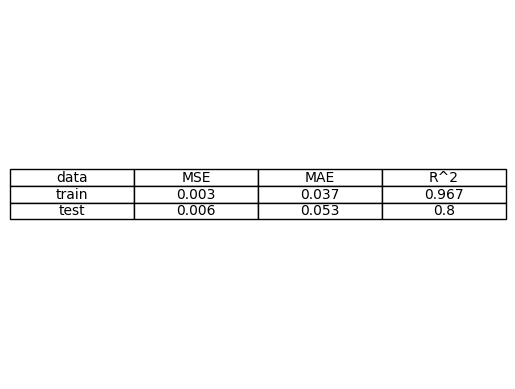

In [21]:
score_table(y_train, y_pred_train, y_test, y_pred_test, f'RBF_{COMPANY}')

## Bulding XGBRegressor model

In [31]:
from xgboost import XGBRegressor
my_model = XGBRegressor(n_estimators=1000)
my_model.fit(X_train, y_train, verbose=False)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=1000, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

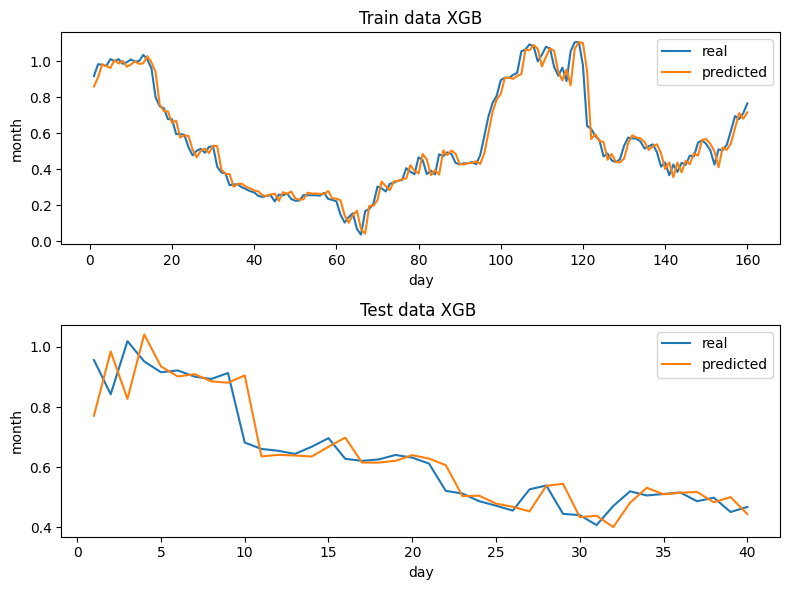

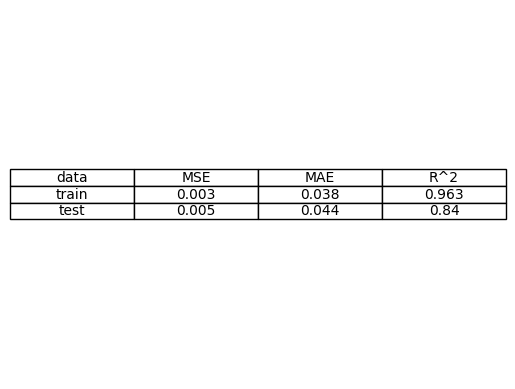

In [32]:
y_pred_train = model.predict(X_train)
y_pred_test = model.predict(X_test)
generate_plots(y_pred_train, y_pred_test, y_train, y_test, 'Train data XGB', 'Test data XGB ', True, f'XGB_{COMPANY}')
score_table(y_train, y_pred_train, y_test, y_pred_test, f'XGB_table_{COMPANY}')

## Bulding LSTM network

In [24]:
model = Sequential()
model.add(LSTM(100, return_sequences=True, input_shape=(X_train.shape[1], 1)))
model.add(Dropout(0.2))
model.add(LSTM(100, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(100, return_sequences=False))
model.add(Dense(25))
model.add(Dense(1))
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 5, 100)            40800     
                                                                 
 dropout (Dropout)           (None, 5, 100)            0         
                                                                 
 lstm_1 (LSTM)               (None, 5, 100)            80400     
                                                                 
 dropout_1 (Dropout)         (None, 5, 100)            0         
                                                                 
 lstm_2 (LSTM)               (None, 100)               80400     
                                                                 
 dense_1 (Dense)             (None, 25)                2525      
                                                                 
 dense_2 (Dense)             (None, 1)                

In [25]:
model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(X_train, y_train, batch_size= 1, epochs=20)

Epoch 1/20
160/160 [==============================] - 5s 6ms/step - loss: 0.0318
Epoch 2/20
160/160 [==============================] - 1s 6ms/step - loss: 0.0211
Epoch 3/20
160/160 [==============================] - 1s 6ms/step - loss: 0.0176
Epoch 4/20
160/160 [==============================] - 1s 5ms/step - loss: 0.0189
Epoch 5/20
160/160 [==============================] - 1s 5ms/step - loss: 0.0186
Epoch 6/20
160/160 [==============================] - 1s 6ms/step - loss: 0.0142
Epoch 7/20
160/160 [==============================] - 1s 7ms/step - loss: 0.0162
Epoch 8/20
160/160 [==============================] - 1s 9ms/step - loss: 0.0128
Epoch 9/20
160/160 [==============================] - 1s 8ms/step - loss: 0.0196
Epoch 10/20
160/160 [==============================] - 1s 6ms/step - loss: 0.0112
Epoch 11/20
160/160 [==============================] - 1s 5ms/step - loss: 0.0076
Epoch 12/20
160/160 [==============================] - 1s 5ms/step - loss: 0.0135
Epoch 13/20
160/160 [====

2/2 [==============================] - 1s 4ms/step


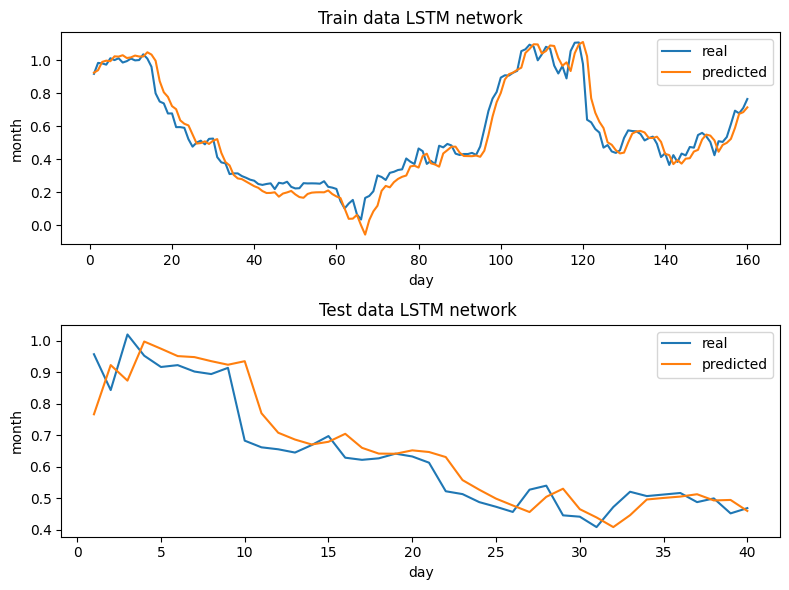

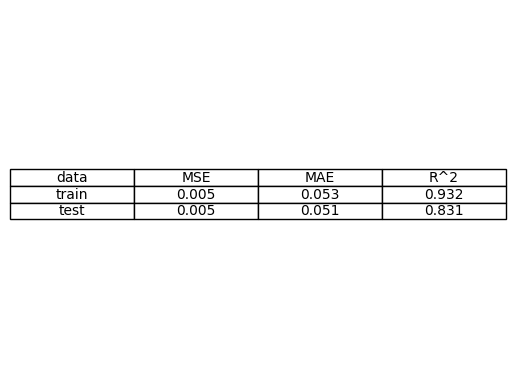

In [26]:
y_pred_train = model.predict(X_train)
y_pred_test = model.predict(X_test)
generate_plots(y_pred_train, y_pred_test, y_train, y_test, 'Train data LSTM network', 'Test data LSTM network ', True, f'LSTM_{COMPANY}')
score_table(y_train, y_pred_train, y_test, y_pred_test, f'LSTM_table_{COMPANY}')

## Bulding Linear regression model

In [27]:
model = LinearRegression()
model.fit(X_train, y_train)

LinearRegression()

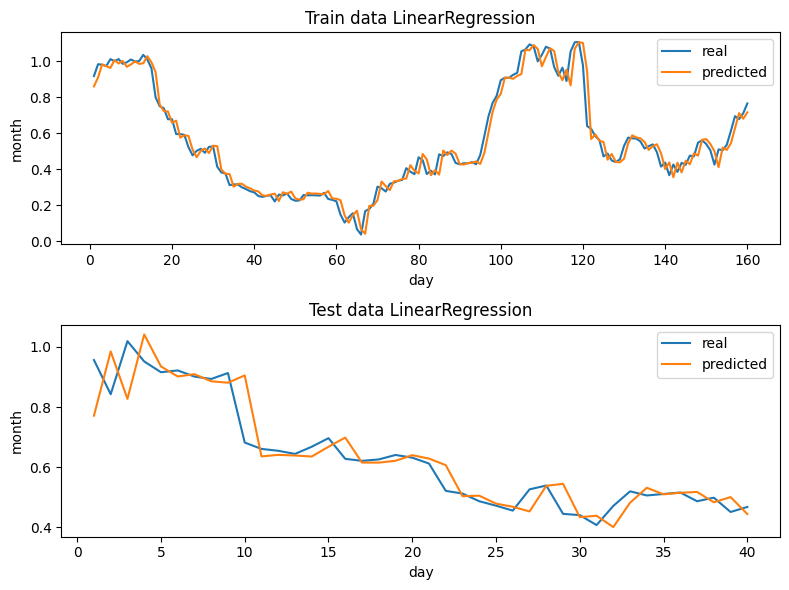

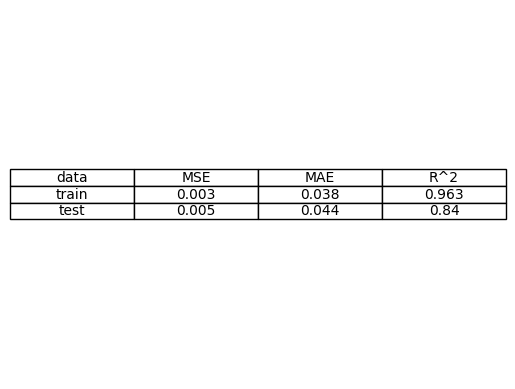

In [28]:
y_pred_train = model.predict(X_train)
y_pred_test = model.predict(X_test)
generate_plots(y_pred_train, y_pred_test, y_train, y_test, 'Train data LinearRegression', 'Test data LinearRegression', True, f'LinearRegression_{COMPANY}')
score_table(y_train, y_pred_train, y_test, y_pred_test, f'LinearRegression_{COMPANY}')